In [31]:
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset

import pytesseract
from PIL import Image

import cv2
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# 시드 고정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# GPU/CPU 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
def visualize_image_from_tensor(tensor, n):
    """
    텐서에서 n번째 샘플을 시각화합니다.

    Parameters:
    - tensor (torch.Tensor): 불러온 이미지 텐서 (N, C, H, W)
    - n (int): 시각화할 샘플의 인덱스 (0부터 시작)

    Raises:
    - ValueError: n이 텐서 범위를 벗어날 경우
    """
    if n < 0 or n >= tensor.size(0):
        raise ValueError(f"인덱스 {n}는 텐서 범위 [0, {tensor.size(0)-1}]를 벗어났습니다.")
    
    # n번째 샘플 추출
    image_tensor = tensor[n]
    
    # 텐서를 numpy 배열로 변환 (H, W, C)
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    
    # 값의 범위를 0-1로 정규화
    if image_np.max() > 1:
        image_np = image_np / 255.0  # 정규화
    
    # 시각화
    plt.imshow(image_np, aspect='equal')  # 가로 세로 비율을 유지
    plt.axis('off')  # 축 제거
    plt.title(f"No. {n}", fontsize=16)
    plt.show()

def collect_all_samples(dataloader):
    # 모든 샘플을 담을 리스트
    all_samples = []

    # DataLoader를 순회하며 데이터를 수집
    # DataLoader에서 TensorDataset이 반환하는 것은 (tensor,) 형태의 튜플이므로 unpack 필요
    for (images,) in dataloader:
        all_samples.append(images)

    # 텐서들을 첫 번째 차원(batch 차원)을 기준으로 이어붙임
    all_samples_tensor = torch.cat(all_samples, dim=0)  # [total_samples, 3, 488, 488]

    return all_samples_tensor

In [3]:
# 저장했던 ROI 이미지 경로 (master image)
txt_region1_path = './master/V160-txt_master_roi1.jpeg'
txt_region2_path = './master/V160-txt_master_roi2.jpeg'
txt_region3_path = './master/V160-txt_master_roi3.jpeg'

# 이미지 로드 (BGR 포맷)
txt_region1 = cv2.imread(txt_region1_path)
txt_region2 = cv2.imread(txt_region2_path)
txt_region3 = cv2.imread(txt_region3_path)

# 필요하다면 시각화를 위해 RGB로 변환
txt_region1 = cv2.cvtColor(txt_region1, cv2.COLOR_BGR2RGB)
txt_region2 = cv2.cvtColor(txt_region2, cv2.COLOR_BGR2RGB)
txt_region3 = cv2.cvtColor(txt_region3, cv2.COLOR_BGR2RGB)

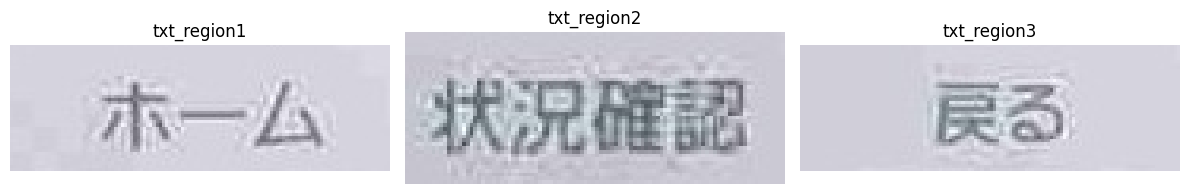

In [4]:
# 확인용 시각화 (1행 3열 서브플롯)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(txt_region1)
axs[0].set_title('txt_region1')
axs[0].axis('off')

axs[1].imshow(txt_region2)
axs[1].set_title('txt_region2')
axs[1].axis('off')

axs[2].imshow(txt_region3)
axs[2].set_title('txt_region3')
axs[2].axis('off')

plt.tight_layout()
plt.show()

# 'text_region1'
- "region_1": (230, 90, 350, 130),  # 첫 번째 영역
# 'text_region2'
- "region_2": (90, 270, 190, 310),   # 두 번째 영역
# 'text_region3'
- "region_3": (230, 270, 350, 310),  # 세 번째 영역

In [5]:
txt_region1 = np.transpose(txt_region1, (2, 0, 1))
txt_region2 = np.transpose(txt_region2, (2, 0, 1))
txt_region3 = np.transpose(txt_region3, (2, 0, 1))

print("Home Button: ", np.shape(txt_region1))
print("Status Button: ", np.shape(txt_region2))
print("Back Button: ", np.shape(txt_region3))

Home Button:  (3, 40, 120)
Status Button:  (3, 40, 100)
Back Button:  (3, 40, 120)


# [ Loading 1st-Cropped Images ]

In [6]:
# numpy 배열을 다시 텐서로 변환
# cropped_left_images      = torch.tensor(np.load('./cropped_left_V160_pass.npy')).float() / 255.0
# cropped_left_images_fail = torch.tensor(np.load('./cropped_left_V160_fail.npy')).float() / 255.0
cropped_left_images      = torch.tensor(np.load('./cropped_left_V160_pass.npy')).float()
cropped_left_images_fail = torch.tensor(np.load('./cropped_left_V160_fail.npy')).float()

# 결과 출력
print("V160 - PASS:", cropped_left_images.shape)
print("V160 - FAIL:", cropped_left_images_fail.shape)

V160 - PASS: torch.Size([3962, 3, 488, 488])
V160 - FAIL: torch.Size([116, 3, 488, 488])


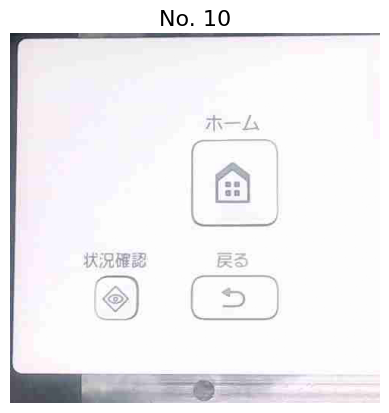

In [7]:
visualize_image_from_tensor(cropped_left_images, 10)

In [8]:
from torch.utils.data import DataLoader, random_split, TensorDataset
def prepare_normal_data_loader(cropped_left_images, batch_size=128, train_ratio=0.95):
    """
    정상 데이터 (cropped_left_images)를 TensorDataset으로 래핑하여 
    train_loader와 test_loader를 생성합니다.

    Parameters:
    - cropped_left_images (torch.Tensor): 정상 데이터 텐서 (N, C, H, W)
    - batch_size (int): 배치 크기. 기본값은 128
    - train_ratio (float): 훈련 데이터 비율. 기본값은 0.95

    Returns:
    - train_loader (DataLoader): 학습용 데이터 로더 (정상 데이터만 포함)
    - test_loader (DataLoader): 테스트용 데이터 로더 (정상 데이터만 포함)
    """
    # TensorDataset으로 래핑
    cropped_left_images_dataset = TensorDataset(cropped_left_images)

    # 데이터셋 크기 계산
    num_samples = len(cropped_left_images_dataset)
    train_size = int(num_samples * train_ratio)
    test_size = num_samples - train_size

    # Train/Test Split
    train_images, test_images = random_split(cropped_left_images_dataset, [train_size, test_size])

    # DataLoader 생성
    train_loader = DataLoader(train_images, batch_size=batch_size, shuffle=True, drop_last=False)
    test_loader = DataLoader(test_images, batch_size=batch_size, shuffle=False, drop_last=False)
    
    return train_loader, test_loader

def prepare_fail_data_loader(cropped_images_fail, batch_size=128):
    """
    불량 데이터 (cropped_images_fail)를 TensorDataset으로 래핑하여 
    test_loader_fail을 생성합니다.

    Parameters:
    - cropped_images_fail (torch.Tensor): 불량 데이터 텐서 (N, C, H, W)
    - batch_size (int): 배치 크기. 기본값은 128

    Returns:
    - test_loader_fail (DataLoader): 테스트용 데이터 로더 (불량 데이터만 포함)
    """
    # TensorDataset으로 변환 후 DataLoader 생성
    fail_dataset = TensorDataset(cropped_images_fail)
    test_loader_fail = DataLoader(fail_dataset, batch_size=batch_size, shuffle=False)
    
    return test_loader_fail

In [9]:
# 정상 데이터 준비
train_loader, test_loader = prepare_normal_data_loader(
    cropped_left_images=cropped_left_images,  # 정상 데이터 텐서
    batch_size=64,
    train_ratio=0.95
)

# 불량 데이터 준비
test_loader_fail = prepare_fail_data_loader(
    cropped_images_fail=cropped_left_images_fail,  # 불량 데이터 텐서
    batch_size=64
)

# 데이터 로더 출력
print(f"Train Loader: {len(train_loader.dataset)} samples")
print(f"Test Loader: {len(test_loader.dataset)} samples")
print(f"Fail Test Loader: {len(test_loader_fail.dataset)} samples")

Train Loader: 3763 samples
Test Loader: 199 samples
Fail Test Loader: 116 samples


In [10]:
train_tensor     = collect_all_samples(train_loader)
test_pass_tensor = collect_all_samples(test_loader)
test_fail_tensor = collect_all_samples(test_loader_fail)

print("Train - Pass: ", train_tensor.shape)
print("Test - Pass: ", test_pass_tensor.shape)
print("Test - Fail: ", test_fail_tensor.shape)

Train - Pass:  torch.Size([3763, 3, 488, 488])
Test - Pass:  torch.Size([199, 3, 488, 488])
Test - Fail:  torch.Size([116, 3, 488, 488])


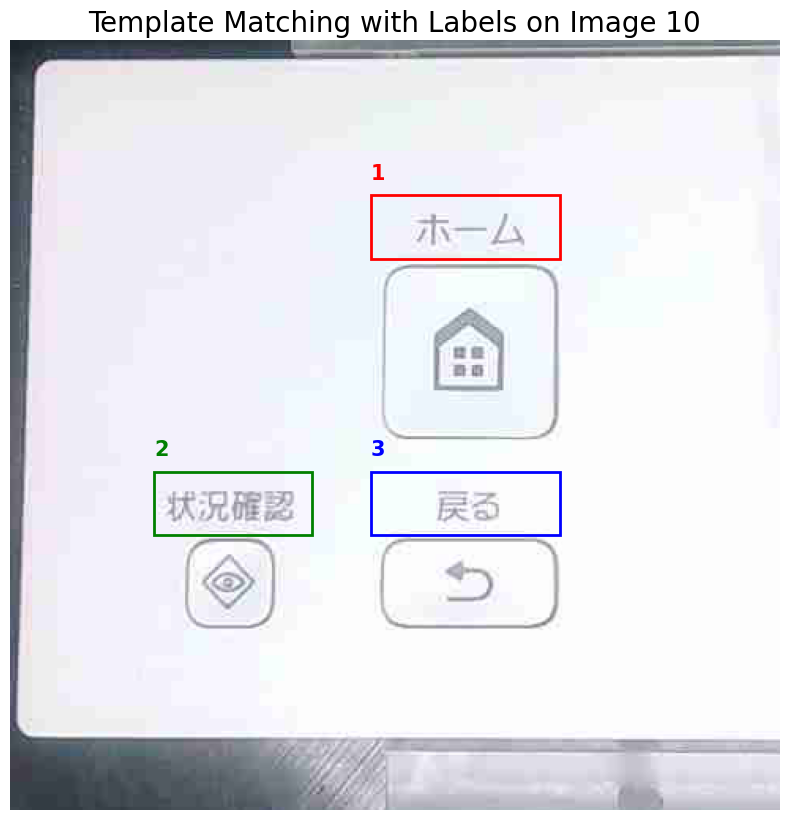

In [11]:
def template_matching(test_tensor, txt_region1, txt_region2, txt_region3, index):
    """
    특정 test_tensor 이미지에서 템플릿 매칭 후 원본 이미지에 박스 및 번호를 시각화하는 함수.
    이미지 자체는 건드리지 않고 plt를 사용해 박스를 그립니다.
    """
    # 텐서에서 이미지 추출 및 [3, H, W] -> [H, W, C]로 변환
    M_i = test_tensor[index].permute(1, 2, 0).numpy()  # 원본 이미지 [H, W, C]
    
    # 이미지 값 정규화 해제 (0~255로 스케일링)
    M_i = (M_i * 255).astype('uint8')  # Matplotlib 시각화에 적합한 타입
    
    # 템플릿을 torch.Tensor로 변환 후 [3, H, W] -> [H, W, C]
    region1 = torch.tensor(txt_region1).permute(1, 2, 0).numpy().astype('uint8')
    region2 = torch.tensor(txt_region2).permute(1, 2, 0).numpy().astype('uint8')
    region3 = torch.tensor(txt_region3).permute(1, 2, 0).numpy().astype('uint8')
    
    # Matplotlib 시각화를 위해 박스와 텍스트 위치를 기록할 리스트
    boxes = []
    
    # 템플릿 매칭 함수
    def match_template(template):
        match_result = cv2.matchTemplate(M_i, template, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(match_result)
        center = (max_loc[0] + template.shape[1] // 2, max_loc[1] + template.shape[0] // 2)
        return center, template.shape[1] // 2, template.shape[0] // 2
    
    # (1) txt_region1 처리
    center1, w_half1, h_half1 = match_template(region1)
    boxes.append((center1, w_half1, h_half1, "1", 'red'))
    
    # (2) txt_region2 처리
    center2, w_half2, h_half2 = match_template(region2)
    boxes.append((center2, w_half2, h_half2, "2", 'green'))
    
    # (3) txt_region3 처리
    center3, w_half3, h_half3 = match_template(region3)
    boxes.append((center3, w_half3, h_half3, "3", 'blue'))
    
    # 원본 이미지 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(M_i)
    
    # 박스와 번호를 시각화
    for center, w_half, h_half, label, color in boxes:
        x, y = center
        rect = plt.Rectangle((x - w_half, y - h_half), w_half * 2, h_half * 2, 
                             linewidth=2, edgecolor=color, facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x - w_half, y - h_half - 10, label, color=color, fontsize=15, weight='bold')
    
    plt.title(f"Template Matching with Labels on Image {index}", fontsize=20)
    plt.axis('off')
    plt.show()

template_matching(test_pass_tensor, txt_region1, txt_region2, txt_region3, index=10)

In [12]:
def process_all_images(test_tensor, txt_region1, txt_region2, txt_region3):
    """
    모든 test_tensor 이미지에 대해 템플릿 매칭, 크롭 및 좌우 보간을 수행.
    
    Parameters:
    - test_tensor (torch.Tensor): 입력 이미지 텐서 [N, C, H, W]
    - txt_region1, txt_region2, txt_region3 (numpy.ndarray): 3개의 템플릿 영역
    
    Returns:
    - cropped_region1, cropped_region2, cropped_region3 (torch.Tensor): 3개의 크롭된 영역 모음
    - interpolated_tensor (torch.Tensor): 좌우 보간이 적용된 이미지 텐서
    """
    N, C, H, W = test_tensor.shape

    # 크롭된 영역 저장
    region1_list, region2_list, region3_list = [], [], []

    # 보간된 이미지를 저장할 텐서
    interpolated_tensor = test_tensor.clone()

    def interpolate_and_fill(image, center, w_half, h_half):
        """
        보간 수행: 원본 RGB 이미지의 좌우 픽셀 값을 기반으로 각 채널별 선형 보간 적용.
        
        Parameters:
        - image (numpy.ndarray): 입력 이미지 [H, W, C]
        - center (tuple): 보간할 영역의 중심 (x, y)
        - w_half (int): 너비의 절반
        - h_half (int): 높이의 절반
        """
        x, y = center
        x1, x2 = x - w_half, x + w_half
        y1, y2 = y - h_half, y + h_half

        # 각 채널에 대해 선형 보간 수행
        for row in range(y1, y2 + 1):
            for c in range(image.shape[2]):  # 각 채널에 대해 반복
                left_value = image[row, x1 - 1, c] if x1 > 0 else 255
                right_value = image[row, x2 + 1, c] if x2 < image.shape[1] - 1 else 255

                # 선형 보간을 적용하여 빈 영역을 채움
                for col in range(x1, x2 + 1):
                    alpha = (col - x1) / (x2 - x1)  # 보간 비율
                    image[row, col, c] = int((1 - alpha) * left_value + alpha * right_value)

    for i in range(N):
        # 이미지 준비 및 변환
        M_i = test_tensor[i].permute(1, 2, 0).numpy()  # [H, W, C]
        M_i = (M_i * 255).astype(np.uint8)
        interpolated_image = M_i.copy()

        # 템플릿 채널 변환
        txt_region1_hw = np.transpose(txt_region1, (1, 2, 0))
        txt_region2_hw = np.transpose(txt_region2, (1, 2, 0))
        txt_region3_hw = np.transpose(txt_region3, (1, 2, 0))

        # 그레이스케일 변환
        region1_gray = cv2.cvtColor(txt_region1_hw, cv2.COLOR_RGB2GRAY)
        region2_gray = cv2.cvtColor(txt_region2_hw, cv2.COLOR_RGB2GRAY)
        region3_gray = cv2.cvtColor(txt_region3_hw, cv2.COLOR_RGB2GRAY)
        M_i_gray = cv2.cvtColor(M_i, cv2.COLOR_RGB2GRAY)

        def match_and_crop(template_gray):
            match_result = cv2.matchTemplate(M_i_gray, template_gray, cv2.TM_CCOEFF_NORMED)
            _, _, _, max_loc = cv2.minMaxLoc(match_result)
            center = (max_loc[0] + template_gray.shape[1] // 2, max_loc[1] + template_gray.shape[0] // 2)
            w_half, h_half = template_gray.shape[1] // 2, template_gray.shape[0] // 2
            return center, w_half, h_half

        # (1) region1 크롭 및 저장
        center1, w_half1, h_half1 = match_and_crop(region1_gray)
        region1 = M_i[center1[1] - h_half1:center1[1] + h_half1, center1[0] - w_half1:center1[0] + w_half1]
        region1_list.append(torch.tensor(region1).permute(2, 0, 1))
        interpolate_and_fill(interpolated_image, center1, w_half1, h_half1)

        # (2) region2 크롭 및 저장
        center2, w_half2, h_half2 = match_and_crop(region2_gray)
        region2 = M_i[center2[1] - h_half2:center2[1] + h_half2, center2[0] - w_half2:center2[0] + w_half2]
        region2_list.append(torch.tensor(region2).permute(2, 0, 1))
        interpolate_and_fill(interpolated_image, center2, w_half2, h_half2)

        # (3) region3 크롭 및 저장
        center3, w_half3, h_half3 = match_and_crop(region3_gray)
        region3 = M_i[center3[1] - h_half3:center3[1] + h_half3, center3[0] - w_half3:center3[0] + w_half3]
        region3_list.append(torch.tensor(region3).permute(2, 0, 1))
        interpolate_and_fill(interpolated_image, center3, w_half3, h_half3)

        # 보간된 이미지 업데이트
        interpolated_tensor[i] = torch.tensor(interpolated_image).permute(2, 0, 1) / 255.0

    # 리스트를 텐서로 변환
    cropped_region1 = torch.stack(region1_list)
    cropped_region2 = torch.stack(region2_list)
    cropped_region3 = torch.stack(region3_list)

    return cropped_region1, cropped_region2, cropped_region3, interpolated_tensor

Cropped Region 1 Shape: torch.Size([199, 3, 40, 120])
Cropped Region 2 Shape: torch.Size([199, 3, 40, 100])
Cropped Region 3 Shape: torch.Size([199, 3, 40, 120])
Interpolated Tensor Shape: torch.Size([199, 3, 488, 488])

Interpolated Train Tensor Shape: torch.Size([3763, 3, 488, 488])


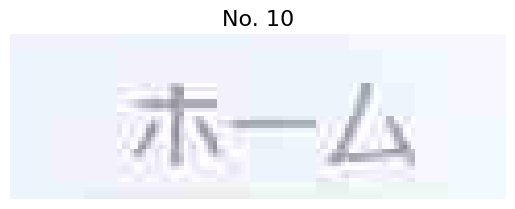

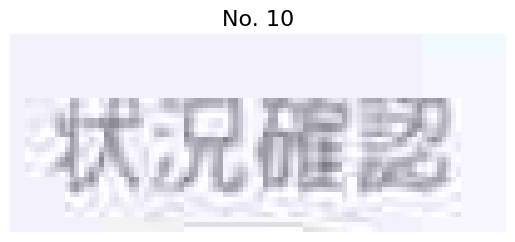

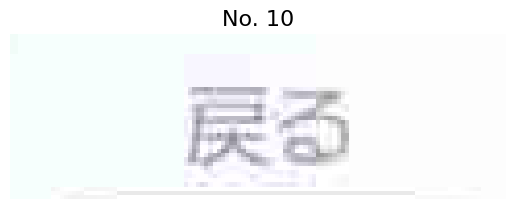

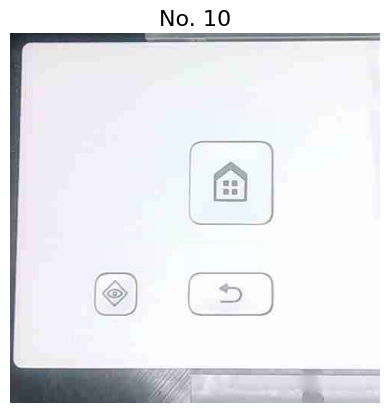

In [13]:
_, _, _, interpolated_train_tensor = process_all_images(
    train_tensor, txt_region1, txt_region2, txt_region3
)

cropped1, cropped2, cropped3, interpolated_pass_tensor = process_all_images(
    test_pass_tensor, txt_region1, txt_region2, txt_region3
)

print("Cropped Region 1 Shape:", cropped1.shape)
print("Cropped Region 2 Shape:", cropped2.shape)
print("Cropped Region 3 Shape:", cropped3.shape)
print("Interpolated Tensor Shape:", interpolated_pass_tensor.shape)
print("\nInterpolated Train Tensor Shape:", interpolated_train_tensor.shape)

# 결과 시각화
n = 10
visualize_image_from_tensor(cropped1, n)
visualize_image_from_tensor(cropped2, n)
visualize_image_from_tensor(cropped3, n)
visualize_image_from_tensor(interpolated_pass_tensor, n)

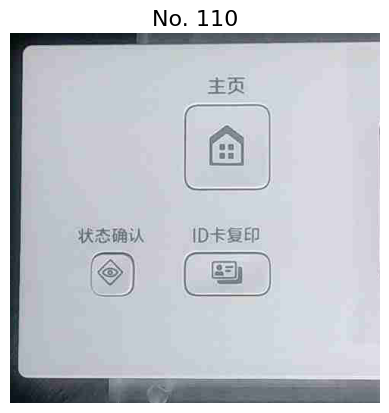

In [20]:
visualize_image_from_tensor(cropped_left_images_fail, n+100)

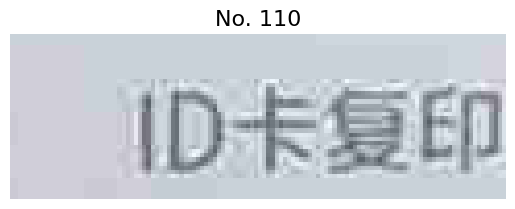

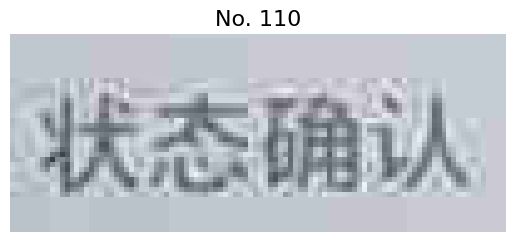

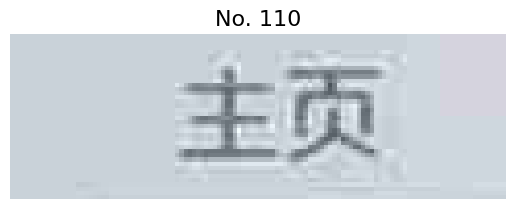

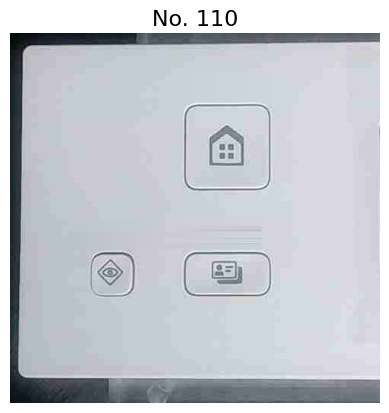

In [19]:
cropped1_fail, cropped2_fail, cropped3_fail, interpolated_fail_tensor = process_all_images(
    test_fail_tensor, txt_region1, txt_region2, txt_region3
)

visualize_image_from_tensor(cropped1_fail, n+100)
visualize_image_from_tensor(cropped2_fail, n+100)
visualize_image_from_tensor(cropped3_fail, n+100)
visualize_image_from_tensor(interpolated_fail_tensor, n+100)

In [18]:
np.save("test_pass_cropped1.npy", cropped1.numpy())
np.save("test_pass_cropped2.npy", cropped2.numpy())
np.save("test_pass_cropped3.npy", cropped3.numpy())
np.save("test_pass_proccessed_tensor.npy", interpolated_pass_tensor.numpy())

np.save("train_pass_proccessed_tensor.npy", interpolated_train_tensor.numpy())

np.save("test_fail_cropped1.npy", cropped1_fail.numpy())
np.save("test_fail_cropped2.npy", cropped2_fail.numpy())
np.save("test_fail_cropped3.npy", cropped3_fail.numpy())
np.save("test_fail_proccessed_tensor.npy", interpolated_fail_tensor.numpy())

print("Files saved successfully!")

Files saved successfully!


# [ Matching ]

In [28]:
# 이미지 전처리 함수
def preprocess_image(region):
    """
    이미지 전처리를 통해 대비를 높이고 노이즈를 줄입니다.
    """
    # Grayscale 변환
    gray = cv2.cvtColor(region, cv2.COLOR_RGB2GRAY)
    
    # 이진화 (Threshold)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 가우시안 블러 (노이즈 제거)
    blur = cv2.GaussianBlur(thresh, (3, 3), 0)
    
    return blur

# OCR 수행 함수
def extract_text_from_region(region, lang='jpn'):
    """
    주어진 이미지 영역에서 OCR을 통해 텍스트를 추출하고 전처리된 이미지를 시각화합니다.
    """
    # 전처리 적용
    processed_region = preprocess_image(region)
    
    # 전처리된 이미지 시각화
    plt.figure(figsize=(5, 3))
    plt.imshow(processed_region, cmap='gray')
    plt.title("Preprocessed Region")
    plt.axis('off')
    plt.show()
    
    # PIL로 변환
    region_pil = Image.fromarray(processed_region)
    
    # OCR 수행
    extracted_text = pytesseract.image_to_string(region_pil, lang=lang, config='--psm 6')
    return extracted_text.strip()

# txt_region1, txt_region2, txt_region3는 [C, H, W] 형태이므로 변환 필요
def ocr_for_master_images(txt_region1, txt_region2, txt_region3):
    """
    마스터 이미지의 세 영역에 대해 OCR을 수행하고 전처리된 이미지를 시각화합니다.
    추출된 텍스트를 변수로 저장합니다.
    """
    global correct_txt_1, correct_txt_2, correct_txt_3  # 전역 변수로 선언

    # 텐서 또는 numpy 배열을 [H, W, C] 형태로 변환
    region1 = np.transpose(txt_region1, (1, 2, 0))
    region2 = np.transpose(txt_region2, (1, 2, 0))
    region3 = np.transpose(txt_region3, (1, 2, 0))
    
    # OCR 수행 및 변수에 저장
    correct_txt_1 = extract_text_from_region(region1, lang='jpn')
    correct_txt_2 = extract_text_from_region(region2, lang='jpn')
    correct_txt_3 = extract_text_from_region(region3, lang='jpn')
    
    # 출력
    print("Extracted Text:")
    print(f"Region 1: {correct_txt_1}")
    print(f"Region 2: {correct_txt_2}")
    print(f"Region 3: {correct_txt_3}")

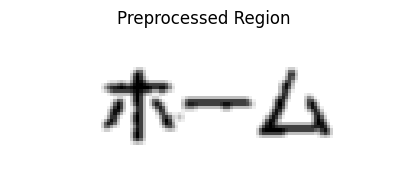

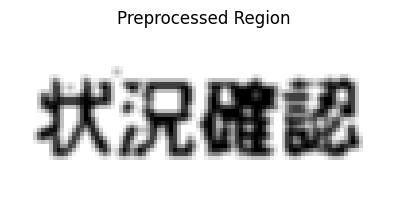

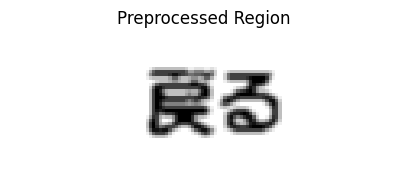

Extracted Text:
Region 1: ホーム
Region 2: 状況確認
Region 3: 戻る

Correct Text Variables:
correct_txt_1: ホーム
correct_txt_2: 状況確認
correct_txt_3: 戻る


In [29]:
# OCR 실행
ocr_for_master_images(txt_region1, txt_region2, txt_region3)

# 변수 값 확인
print("\nCorrect Text Variables:")
print("correct_txt_1:", correct_txt_1)
print("correct_txt_2:", correct_txt_2)
print("correct_txt_3:", correct_txt_3)

In [38]:
from concurrent.futures import ProcessPoolExecutor

In [39]:
from concurrent.futures import ProcessPoolExecutor
# 이미지 전처리 함수
def preprocess_image(region):
    gray = cv2.cvtColor(region, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(thresh, (3, 3), 0)
    return blur

# OCR 수행 함수
def extract_text_from_region(region, lang='jpn'):
    processed_region = preprocess_image(region)
    region_pil = Image.fromarray(processed_region)
    extracted_text = pytesseract.image_to_string(region_pil, lang=lang, config='--psm 6')
    return extracted_text.strip()

# 병렬로 OCR을 수행하는 함수
def process_single_sample(index, cropped1, cropped2, cropped3, correct_txt_1, correct_txt_2, correct_txt_3):
    """
    단일 샘플에 대해 OCR과 Levenshtein Distance를 계산합니다.
    """
    # 이미지 처리
    region1_np = cropped1[index].permute(1, 2, 0).cpu().numpy()
    region2_np = cropped2[index].permute(1, 2, 0).cpu().numpy()
    region3_np = cropped3[index].permute(1, 2, 0).cpu().numpy()
    
    # 텍스트 인식
    text1 = extract_text_from_region(region1_np, lang='jpn')
    text2 = extract_text_from_region(region2_np, lang='jpn')
    text3 = extract_text_from_region(region3_np, lang='jpn')
    
    # Levenshtein Distance 및 정답률 계산
    levenshtein_1 = levenshtein_distance(text1, correct_txt_1)
    levenshtein_2 = levenshtein_distance(text2, correct_txt_2)
    levenshtein_3 = levenshtein_distance(text3, correct_txt_3)

    correct_rate_1 = 1 - levenshtein_1 / max(len(correct_txt_1), len(text1) or 1)
    correct_rate_2 = 1 - levenshtein_2 / max(len(correct_txt_2), len(text2) or 1)
    correct_rate_3 = 1 - levenshtein_3 / max(len(correct_txt_3), len(text3) or 1)

    return index, text1, text2, text3, correct_rate_1, correct_rate_2, correct_rate_3

# 메인 함수: 병렬 처리 버전
def process_cropped_images_parallel(cropped1, cropped2, cropped3, correct_txt_1, correct_txt_2, correct_txt_3):
    N = cropped1.shape[0]
    df = pd.DataFrame(columns=['region_1', 'region_2', 'region_3', 
                               'correct_rate_1', 'correct_rate_2', 'correct_rate_3'])

    # 병렬 처리
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(process_single_sample, i, cropped1, cropped2, cropped3,
                                   correct_txt_1, correct_txt_2, correct_txt_3) for i in range(N)]

        for future in futures:
            index, text1, text2, text3, rate1, rate2, rate3 = future.result()
            df.loc[index] = [text1, text2, text3, rate1, rate2, rate3]

    return df

# 실행
df_test_pass = process_cropped_images_parallel(cropped1, cropped2, cropped3,
                                               correct_txt_1, correct_txt_2, correct_txt_3)
df_test_fail = process_cropped_images_parallel(cropped1_fail, cropped2_fail, cropped3_fail,
                                               correct_txt_1, correct_txt_2, correct_txt_3)

print(df_test_pass.head())
print(df_test_fail.head())

  region_1 region_2 region_3  correct_rate_1  correct_rate_2  correct_rate_3
0      ホーム     状況確認       戻る             1.0            1.00             1.0
1      ホーム     状況確認       戻る             1.0            1.00             1.0
2      ホーム      状況認       戻る             1.0            0.75             1.0
3      ホーム     状況確認       戻る             1.0            1.00             1.0
4      ホーム     状況確認       戻る             1.0            1.00             1.0
  region_1 region_2 region_3  correct_rate_1  correct_rate_2  correct_rate_3
0      上一歩     状赤克込       Eゴ             0.0            0.25             0.0
1      上一歩      状赤太       主列             0.0            0.25             0.0
2      上一歩     状恋克込       主草             0.0            0.25             0.0
3      上一歩     状赤左込     大赤克込             0.0            0.25             0.0
4      上一歩     状恋右込       主項             0.0            0.25             0.0


In [43]:
# df_test_pass.describe()

df_test_pass

,region_1,region_2,region_3,correct_rate_1,correct_rate_2,correct_rate_3
0,ホーム,状況確認,戻る,1.0,1.00,1.0
1,ホーム,状況確認,戻る,1.0,1.00,1.0
2,ホーム,状況認,戻る,1.0,0.75,1.0
3,ホーム,状況確認,戻る,1.0,1.00,1.0
4,ホーム,状況確認,戻る,1.0,1.00,1.0
...,...,...,...,...,...,...
194,ホーム,状況確認,戻る,1.0,1.00,1.0
195,ホーム,状況確認,戻る,1.0,1.00,1.0
196,ホーム,状況確認,戻る,1.0,1.00,1.0
197,ホーム,状況確認,戻る,1.0,1.00,1.0


In [41]:
df_test_fail

,region_1,region_2,region_3,correct_rate_1,correct_rate_2,correct_rate_3
0,上一歩,状赤克込,Eゴ,0.0,0.25,0.0
1,上一歩,状赤太,主列,0.0,0.25,0.0
2,上一歩,状恋克込,主草,0.0,0.25,0.0
3,上一歩,状赤左込,大赤克込,0.0,0.25,0.0
4,上一歩,状恋右込,主項,0.0,0.25,0.0
...,...,...,...,...,...,...
111,ID本哀印,状赤太,主瑞,0.0,0.25,0.0
112,ID本昌印,状恋太,D本昌印,0.0,0.25,0.0
113,ID本條印,状赤礁入,D玉條印,0.0,0.25,0.0
114,ID本夏印,状赤如込,状赤秦込,0.0,0.25,0.0


In [44]:
# correct_rate_3 열에서 최소값을 가지는 행의 인덱스 찾기
min_index = df_test_pass['correct_rate_3'].idxmin()

print(f"The index of the row with the smallest correct_rate_3: {min_index}")

The index of the row with the smallest correct_rate_3: 59


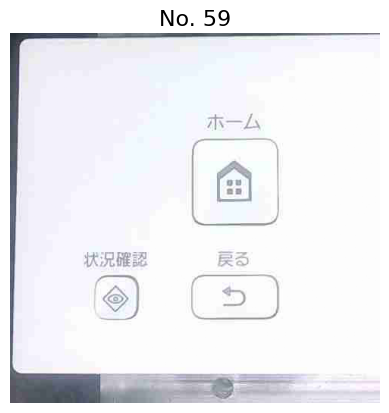

In [45]:
visualize_image_from_tensor(cropped_left_images, 59)

In [46]:
row_59 = df_test_pass.iloc[59]  # 59번째 행은 인덱스 58에 위치

print(row_59)

region_1           ホーム
region_2          状況確認
region_3            太る
correct_rate_1     1.0
correct_rate_2     1.0
correct_rate_3     0.5
Name: 59, dtype: object
